# Hostpial Data Visualization

In [9]:
# All libraries should be downloaded.
import pandas as pd
import matplotlib as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD


In [10]:
# Getting Hospital Data
import pandas as pd
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_1 = "SELECT * FROM hospital;"
query_2 = "SELECT * FROM beds"
query_3 = "SELECT * FROM quality"

hospital_df = pd.read_sql(query_1, conn)
beds_df = pd.read_sql(query_2, conn)
quality_df = pd.read_sql(query_3, conn)

conn.close()

<ipython-input-10-04b7f9cc0468>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hospital_df = pd.read_sql(query_1, conn)
<ipython-input-10-04b7f9cc0468>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)
<ipython-input-10-04b7f9cc0468>:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  quality_df = pd.read_sql(query_3, conn)


# `hospital` Data Frame Exploration

## Data Summary

In [12]:
import pandas as pd
import matplotlib as plt

hospital_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hospital_pk    4996 non-null   object 
 1   hospital_name  4996 non-null   object 
 2   address        4996 non-null   object 
 3   city           4996 non-null   object 
 4   zip            4996 non-null   object 
 5   fips_code      4996 non-null   object 
 6   state          4996 non-null   object 
 7   latitude       4509 non-null   float64
 8   longitude      4509 non-null   float64
dtypes: float64(2), object(7)
memory usage: 351.4+ KB


<ipython-input-4-0d65e14e68ef>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


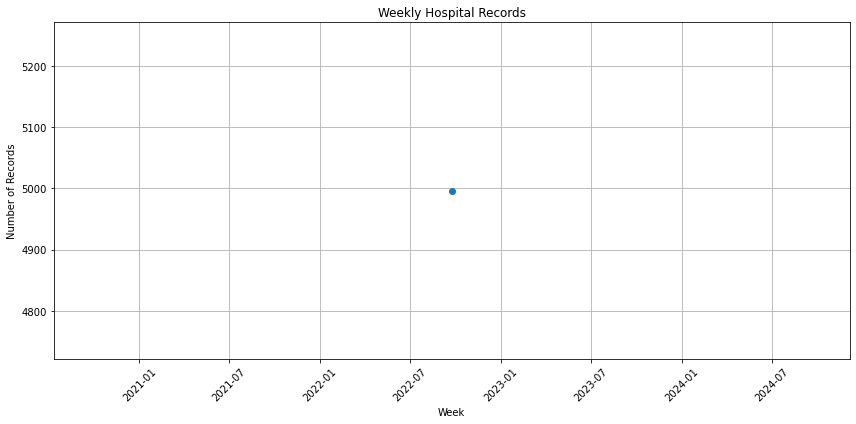

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_2 = "SELECT * FROM beds"

beds_df = pd.read_sql(query_2, conn)

conn.close()

beds_df['collection_week'] = pd.to_datetime(beds_df['collection_week'])
weekly_counts = beds_df.groupby('collection_week').size().reset_index(name='record_count')
weekly_counts.sort_values('collection_week', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(weekly_counts['collection_week'], weekly_counts['record_count'], marker='o')
plt.xlabel('Week')
plt.ylabel('Number of Records')
plt.title('Weekly Hospital Records')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_2 = "SELECT * FROM beds"

beds_df = pd.read_sql(query_2, conn)

conn.close()

weekly_summary = beds_df.groupby('collection_week').agg({
    'all_adult_hospital_beds_7_day_avg': 'sum',
    'all_pediatric_inpatient_beds_7_day_avg': 'sum',
    'all_adult_hospital_inpatient_bed_occupied_7_day_coverage': 'sum',
    'all_pediatric_inpatient_bed_occupied_7_day_avg': 'sum',
    'inpatient_beds_used_covid_7_day_avg': 'sum'
}).reset_index()

weekly_summary.sort_values('collection_week', ascending=False, inplace=True)
comparison_weeks = weekly_summary.head(5)
comparison_weeks

<ipython-input-5-a41a827fd1ce>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


,collection_week,all_adult_hospital_beds_7_day_avg,all_pediatric_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,all_pediatric_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg
0,2022-09-23,-10586399.5,-430959964.5,34832.0,-634971586.9,-1.914972e+09


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_2 = "SELECT * FROM beds"
query_3 = "SELECT * FROM quality"

beds_df = pd.read_sql(query_2, conn)
quality_df = pd.read_sql(query_3, conn)

conn.close()

# Merge the beds and quality dataframes on the hospital identifier
merged_df = pd.merge(beds_df, quality_df, left_on='hospital_pk', right_on='facility_id')

# Calculating total beds and beds in use
merged_df['total_beds'] = merged_df['all_adult_hospital_beds_7_day_avg'] + merged_df['all_pediatric_inpatient_beds_7_day_avg']
merged_df['beds_in_use'] = merged_df['all_adult_hospital_inpatient_bed_occupied_7_day_coverage'] + merged_df['all_pediatric_inpatient_bed_occupied_7_day_avg']

# Calculating the fraction of beds in use
merged_df['fraction_beds_in_use'] = merged_df['beds_in_use'] / merged_df['total_beds']

# Grouping by quality rating and calculating the average fraction
quality_bed_usage = merged_df.groupby('quality_rating')['fraction_beds_in_use'].mean().reset_index()

# Checking the output before plotting
quality_bed_usage

<ipython-input-11-512895399a4f>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)
<ipython-input-11-512895399a4f>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  quality_df = pd.read_sql(query_3, conn)


,quality_rating,fraction_beds_in_use
0,1.0,NaN
1,2.0,NaN
2,3.0,NaN
3,4.0,NaN
4,5.0,-379.261089


<ipython-input-12-b211392e5ea2>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


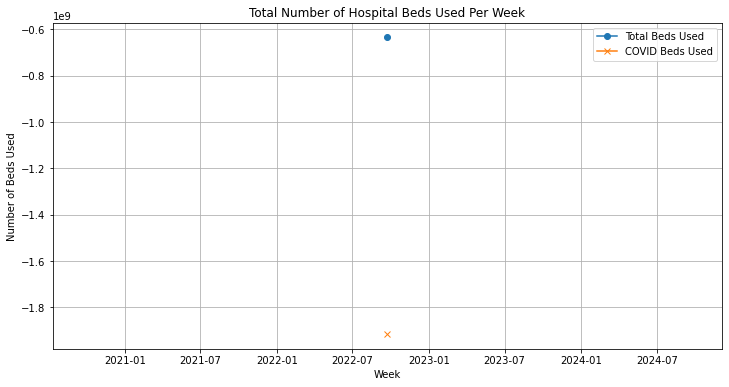

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_2 = "SELECT * FROM beds"

beds_df = pd.read_sql(query_2, conn)

conn.close()

# Ensuring 'collection_week' is a datetime object for proper comparison and sorting
beds_df['collection_week'] = pd.to_datetime(beds_df['collection_week'])

# Calculating the total number of beds used and beds used for COVID per week
weekly_beds_usage = beds_df.groupby('collection_week').agg({
    'all_adult_hospital_inpatient_bed_occupied_7_day_coverage': 'sum',
    'all_pediatric_inpatient_bed_occupied_7_day_avg': 'sum',
    'inpatient_beds_used_covid_7_day_avg': 'sum'
}).reset_index()

# Calculating total beds used (all cases)
weekly_beds_usage['total_beds_used'] = (weekly_beds_usage['all_adult_hospital_inpatient_bed_occupied_7_day_coverage'] +
                                        weekly_beds_usage['all_pediatric_inpatient_bed_occupied_7_day_avg'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_beds_usage['collection_week'], weekly_beds_usage['total_beds_used'], label='Total Beds Used', marker='o')
plt.plot(weekly_beds_usage['collection_week'], weekly_beds_usage['inpatient_beds_used_covid_7_day_avg'], label='COVID Beds Used', marker='x')
plt.xlabel('Week')
plt.ylabel('Number of Beds Used')
plt.title('Total Number of Hospital Beds Used Per Week')
plt.legend()
plt.grid(True)
plt.show()